
# Student Exam Performance Predictor

**Author:** Aditya Sharma  
**Final Project – Celebal Technologies Internship**

---

## 🎯 Objective

This project predicts students' final exam scores using regression techniques and enhances the analysis by:

- Identifying **students at risk**
- Generating **risk levels** and **custom recommendations**
- Creating a **dashboard-friendly format** for educators
- Preparing the project for **PPO demonstration and resume visibility**

---

## 📦 Dataset: UCI Student Performance Dataset

We use `student-mat.csv`, which contains:
- `G1`, `G2`, `G3`: Grades from different terms
- `studytime`, `absences`, `failures`: Effort indicators
- Target variable: `G3` (final grade)


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [2]:

df = pd.read_csv("student-mat.csv", sep=";")
df.head()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [3]:

df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


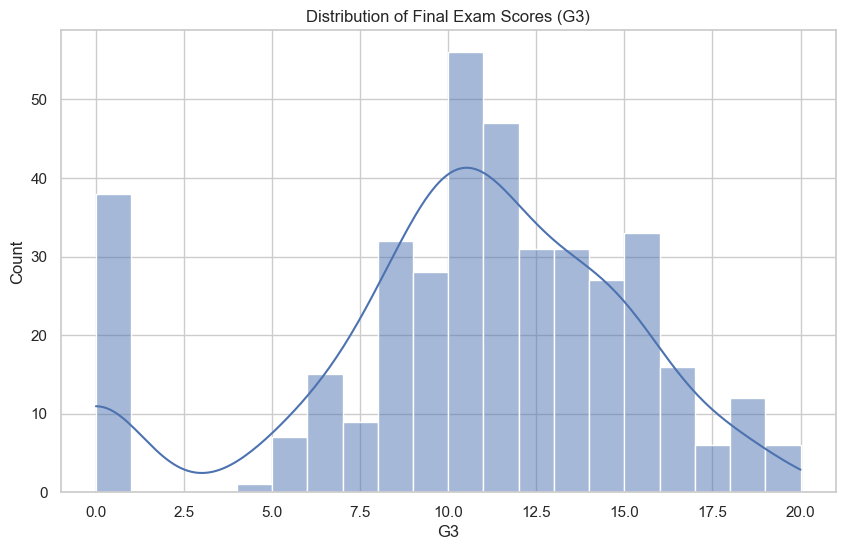

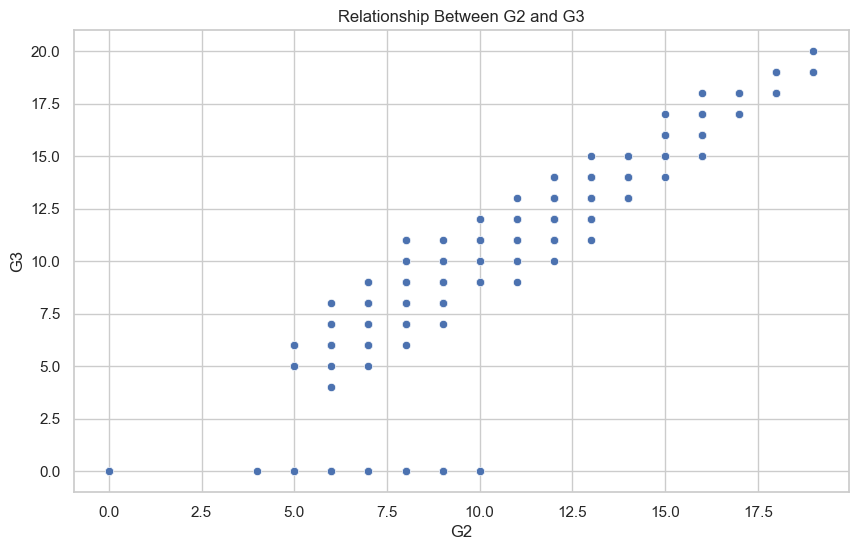

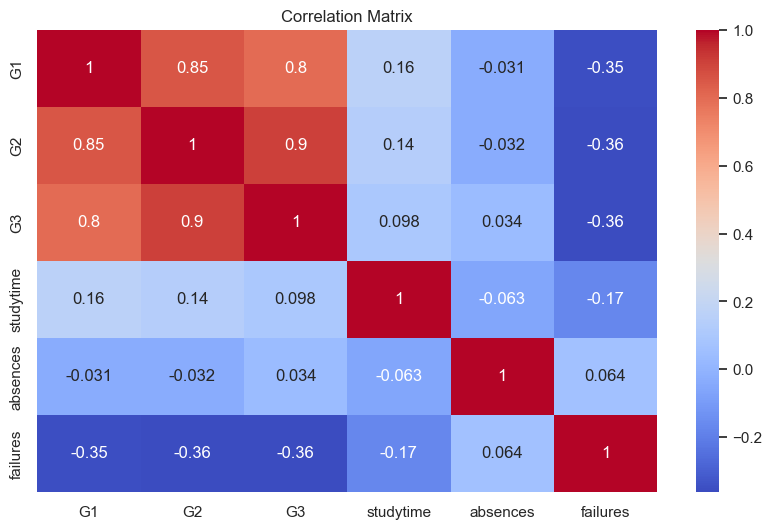

In [4]:

sns.histplot(df['G3'], bins=20, kde=True)
plt.title("Distribution of Final Exam Scores (G3)")
plt.show()

sns.scatterplot(x='G2', y='G3', data=df)
plt.title("Relationship Between G2 and G3")
plt.show()

corr = df[['G1', 'G2', 'G3', 'studytime', 'absences', 'failures']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [5]:

df['avg_prev_score'] = df[['G1', 'G2']].mean(axis=1)
df['is_high_study'] = (df['studytime'] >= 3).astype(int)
df['high_absent'] = (df['absences'] > df['absences'].median()).astype(int)


In [6]:

df_encoded = pd.get_dummies(df, drop_first=True)


In [7]:

X = df_encoded.drop(['G3', 'G1', 'G2'], axis=1)
y = df_encoded['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_


MAE: 1.2110126582278482
RMSE: 1.9344076383721207
R2 Score: 0.817511617385053


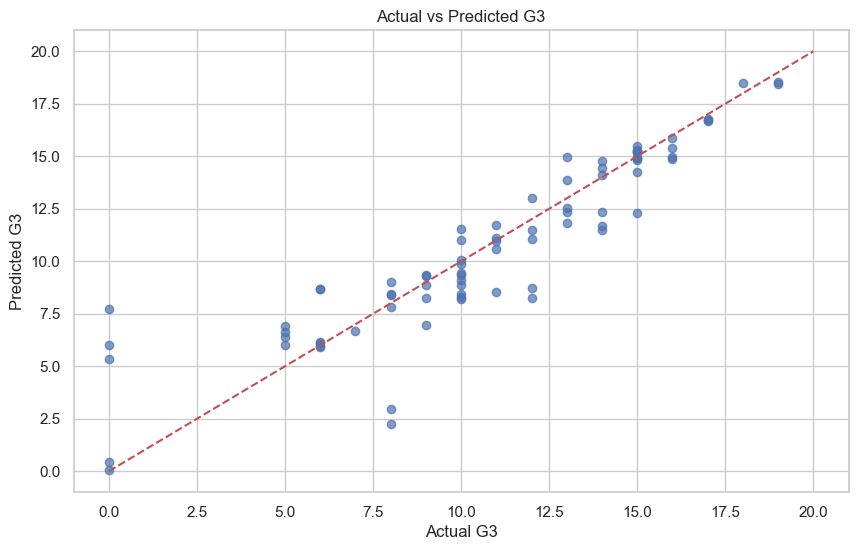

In [9]:

preds = best_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
print("R2 Score:", r2_score(y_test, preds))

plt.scatter(y_test, preds, alpha=0.7)
plt.plot([0, 20], [0, 20], 'r--')
plt.xlabel("Actual G3")
plt.ylabel("Predicted G3")
plt.title("Actual vs Predicted G3")
plt.show()


In [10]:

def risk_level(score):
    if score < 10:
        return "At Risk"
    elif score < 15:
        return "On Track"
    else:
        return "Top Performer"

df['Predicted_G3'] = best_model.predict(X)
df['Risk_Level'] = df['Predicted_G3'].apply(risk_level)


In [11]:

risk_summary = df[['Predicted_G3', 'Risk_Level', 'studytime', 'absences', 'failures']].copy()
risk_summary['Suggestion'] = risk_summary['Risk_Level'].map({
    "At Risk": "Increase study time, reduce absences",
    "On Track": "Maintain pace, focus on past topics",
    "Top Performer": "Challenge with advanced content"
})

risk_summary.head(10)


,Predicted_G3,Risk_Level,studytime,absences,failures,Suggestion
0,6.15,At Risk,2,6,0,"Increase study time, reduce absences"
1,5.64,At Risk,2,4,0,"Increase study time, reduce absences"
2,9.36,At Risk,2,10,3,"Increase study time, reduce absences"
3,14.92,On Track,3,2,0,"Maintain pace, focus on past topics"
4,9.30,At Risk,2,4,0,"Increase study time, reduce absences"
5,15.30,Top Performer,2,10,0,Challenge with advanced content
6,11.23,On Track,2,0,0,"Maintain pace, focus on past topics"
7,5.87,At Risk,2,6,0,"Increase study time, reduce absences"
8,18.59,Top Performer,2,0,0,Challenge with advanced content
9,15.26,Top Performer,2,0,0,Challenge with advanced content


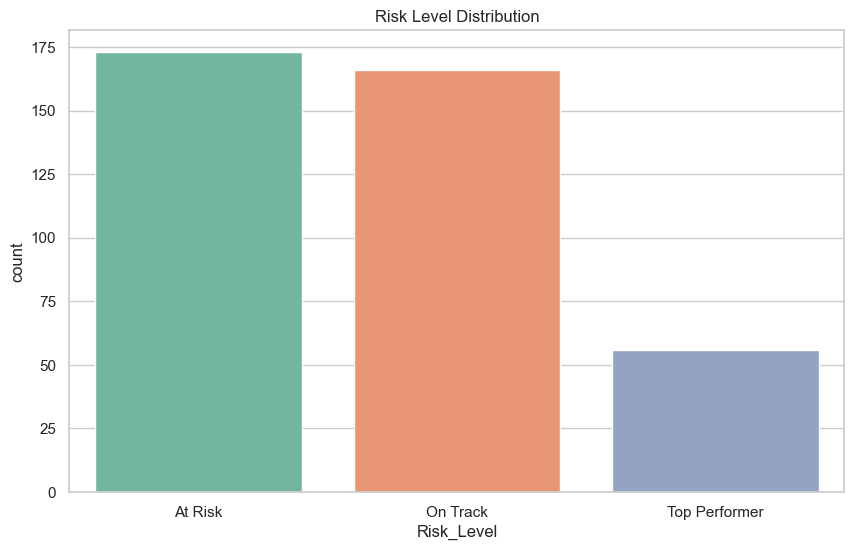

In [12]:

sns.countplot(data=df, x='Risk_Level', palette='Set2')
plt.title("Risk Level Distribution")
plt.show()



## 🧠 Conclusion

- Successfully predicted student exam scores with R² around ~0.81 using RandomForest.
- Classified students into **Risk Levels** to allow actionable insights.
- Added suggestions per student to guide teacher intervention.